In [1]:
from DataLoader import load_data
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import re
import ast

In [2]:
df = pd.read_csv('train_dataset.csv')

def clean_bbox(bbox_str):
    clean_str = re.sub(r'[^\d,.]', '', bbox_str)
    bbox = tuple(map(float, clean_str.split(',')))
    return bbox

df['bbox'] = df['bbox'].apply(clean_bbox)

masked_images, images, masks, labels = load_data(df)
labels = labels - 1 

Failed to load image at Dataset-20240319T181738Z-001/Dataset/PineNutsSeedXrays/Pine Nuts/21_HECOC8_PN_P22.png
Failed to load image at Dataset-20240319T181738Z-001/Dataset/PineNutsSeedXrays/Pine Nuts/21_HECOC8_PN_P22.png
Failed to load image at Dataset-20240319T181738Z-001/Dataset/PineNutsSeedXrays/Pine Nuts/21_HECOC8_PN_P22.png
Failed to load image at Dataset-20240319T181738Z-001/Dataset/PineNutsSeedXrays/Pine Nuts/21_HECOC8_PN_P22.png


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)
train_generator = datagen.flow(
    x=masked_images,
    y=labels,
    batch_size=32,
    subset='training'  # Specify this as training data
)

validation_generator = datagen.flow(
    x=masked_images,
    y=labels,
    batch_size=32,
    subset='validation'  # Specify this as validation data
)


In [4]:
masked_images.shape

(352, 256, 256, 3)

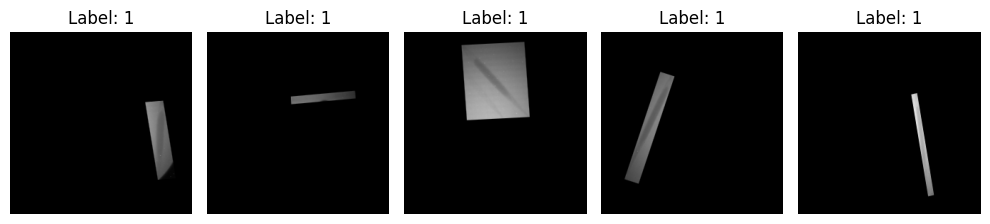

In [7]:
import matplotlib.pyplot as plt

def plot_images_from_generator(generator, num_images=5):
    # Get a batch of images
    data_batch = next(generator)
    images_batch = data_batch[0]  # X values (images)
    labels_batch = data_batch[1]  # Y values (labels)

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images_batch[i]
        if image.shape[-1] == 1: 
            image = image.squeeze()  
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.title(f'Label: {labels_batch[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_images_from_generator(train_generator, num_images=5)


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Use 'softmax' if more than two classes

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
9/9 [==============================] - 120s 13s/step - loss: 0.4620 - accuracy: 0.8262 - val_loss: 0.4773 - val_accuracy: 0.8429
Epoch 2/10
9/9 [==============================] - 112s 13s/step - loss: 0.4290 - accuracy: 0.8440 - val_loss: 0.4432 - val_accuracy: 0.8429
Epoch 3/10
9/9 [==============================] - 111s 12s/step - loss: 0.4451 - accuracy: 0.8511 - val_loss: 0.4496 - val_accuracy: 0.8429
Epoch 4/10
9/9 [==============================] - 115s 13s/step - loss: 0.4341 - accuracy: 0.8511 - val_loss: 0.4420 - val_accuracy: 0.8429
Epoch 5/10
9/9 [==============================] - 123s 14s/step - loss: 0.4433 - accuracy: 0.8511 - val_loss: 0.4404 - val_accuracy: 0.8429
Epoch 6/10
9/9 [==============================] - 128s 14s/step - loss: 0.4329 - accuracy: 0.8511 - val_loss: 0.4435 - val_accuracy: 0.8429
Epoch 7/10
9/9 [==============================] - 131s 15s/step - loss: 0.4242 - accuracy: 0.8511 - val_loss: 0.4406 - val_accuracy: 0.8429
Epoch 8/10
9/9 [====

In [10]:
model.save('AugmentationBaseModel')  

INFO:tensorflow:Assets written to: AugmentationBaseModel\assets


INFO:tensorflow:Assets written to: AugmentationBaseModel\assets


In [11]:
# Extracting accuracy and loss history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [12]:
import matplotlib.pyplot as plt

def plot_learning_curves(acc, val_acc, loss, val_loss, title='Model Learning Curve'):
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.show()


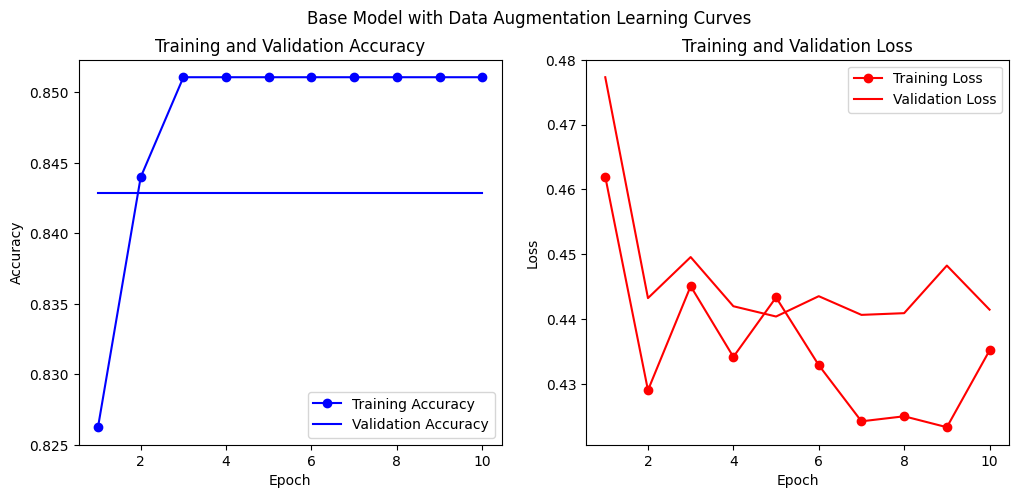

In [13]:
# Plot learning curves
plot_learning_curves(acc, val_acc, loss, val_loss, 'Base Model with Data Augmentation Learning Curves')
